### **Importing Library**

In [173]:
!pip install pmdarima


In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## **Time series**

In [195]:
# reading dataset
customers_df = pd.read_csv('Customer.csv', sep =';')
product_df = pd.read_csv('Product.csv', sep =';')
store_df = pd.read_csv('Store.csv', sep =';')
transaction_df = pd.read_csv('Transaction.csv', sep =';')

In [196]:
store_df.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [197]:
customers_df.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [198]:
product_df.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [199]:
transaction_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [200]:
#Check Shape
print("customer shape ",customers_df.shape)
print("product shape ",product_df.shape)
print("store shape ",store_df.shape)
print("transaction shape ",transaction_df.shape)

customer shape  (447, 5)
product shape  (10, 3)
store shape  (14, 6)
transaction shape  (5020, 8)


In [201]:
#Customer Data
customers_df['Income'] = customers_df['Income'].replace('[,]','.', regex=True).astype('float')
#Store Data
store_df['Latitude'] = store_df['Latitude'].replace('[,]','.', regex=True).astype('float')
store_df['Longitude'] = store_df['Longitude'].replace('[,]','.', regex=True).astype('float')

In [202]:
#Transaction Data
transaction_df['Date'] = pd.to_datetime(transaction_df['Date'])

In [203]:
#Merge Data
df_merge = pd.merge(transaction_df, customers_df, on=['CustomerID'])
df_merge = pd.merge(df_merge, product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, store_df, on=['StoreID'])

In [204]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [205]:
df_reggression = df_merge.groupby(['Date']).agg({
    'Qty':'sum'}
).reset_index()

In [206]:
df_reggression

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

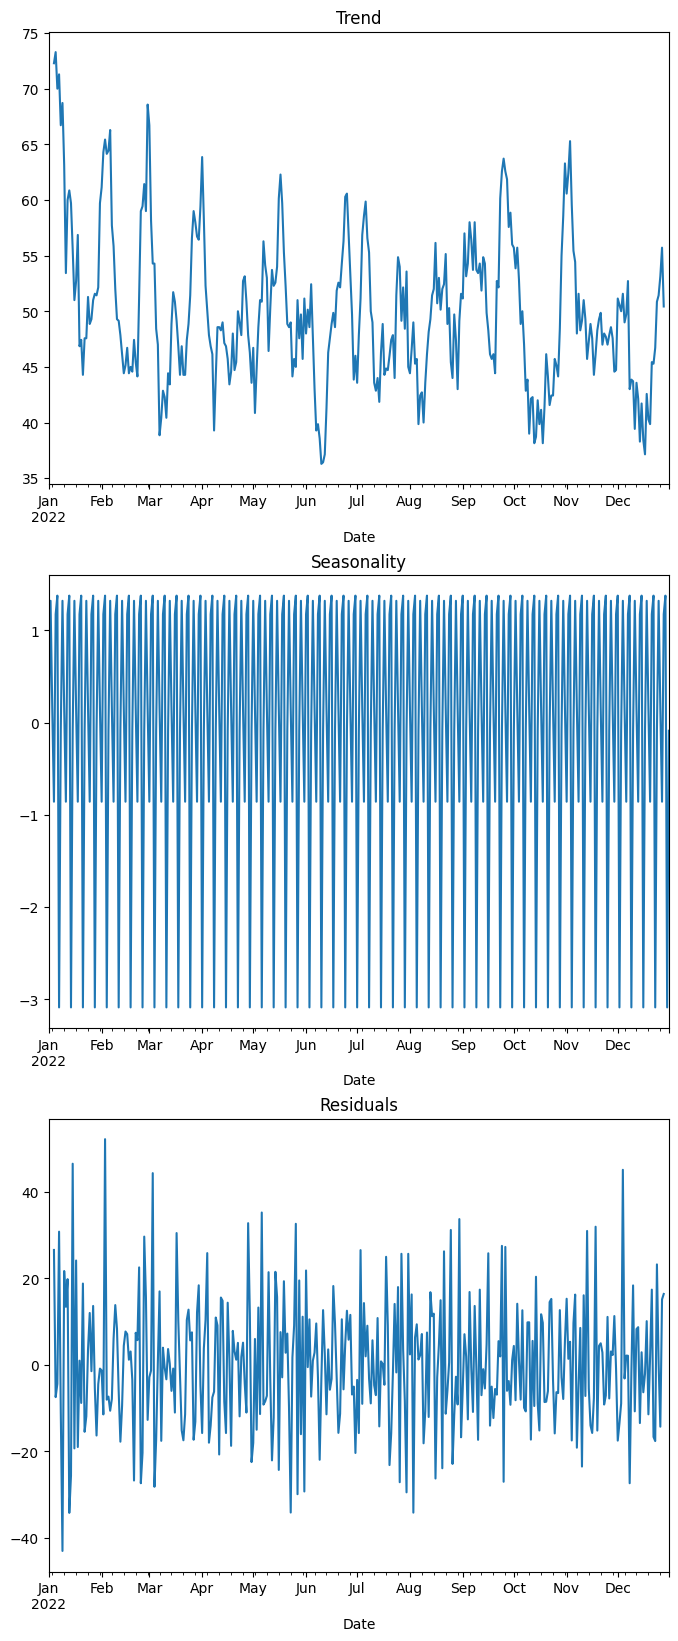

In [207]:
#period = 12
decomposed = seasonal_decompose (df_reggression.set_index("Date"))
plt.figure(figsize=(8, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title( 'Residuals')
plt.tight_layout

In [208]:
cut_off = round(df_reggression.shape[0] * 0.9)
train = df_reggression[:cut_off]
test = df_reggression[cut_off:].reset_index(drop=True)
train.shape, test.shape

((328, 2), (37, 2))

<Axes: xlabel='Date', ylabel='Qty'>

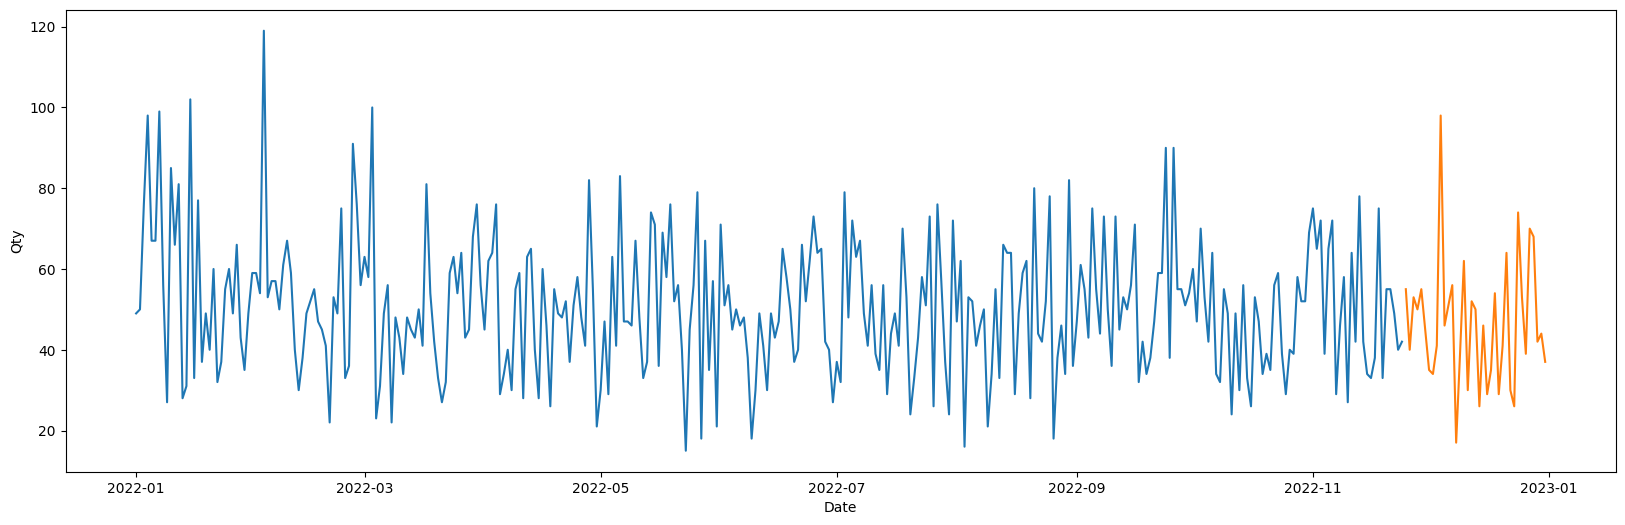

In [209]:
plt.figure(figsize=(20,6))
sns.lineplot(data=train, x=train['Date'], y=train['Qty'])
sns.lineplot(data=test, x=test['Date'], y=test['Qty'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

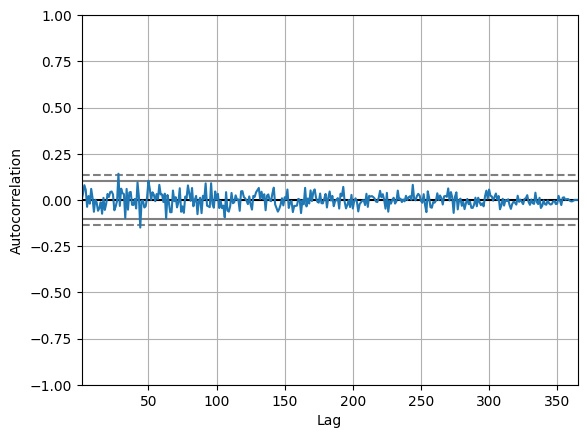

In [210]:
autocorrelation_plot(df_reggression['Qty'])

In [211]:
def rase(y_actual, y_pred): #Func to calculate MSE
  print(f'RMSE Value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval (y_actual, y_pred): #Eval Function ML modelling

  rase(y_actual, y_pred)
  print(f'MAE Value {mean_absolute_error, y_actual, y_pred}')

RMSE Value 15.989408875279329
MAE Value (<function mean_absolute_error at 0x7aa0067d7880>, Date
2022-11-25    55
2022-11-26    40
2022-11-27    53
2022-11-28    50
2022-11-29    55
2022-11-30    45
2022-12-01    35
2022-12-02    34
2022-12-03    41
2022-12-04    98
2022-12-05    46
2022-12-06    51
2022-12-07    56
2022-12-08    17
2022-12-09    39
2022-12-10    62
2022-12-11    30
2022-12-12    52
2022-12-13    50
2022-12-14    26
2022-12-15    46
2022-12-16    29
2022-12-17    35
2022-12-18    54
2022-12-19    29
2022-12-20    41
2022-12-21    64
2022-12-22    30
2022-12-23    26
2022-12-24    74
2022-12-25    53
2022-12-26    39
2022-12-27    70
2022-12-28    68
2022-12-29    42
2022-12-30    44
2022-12-31    37
Name: Qty, dtype: int64, Date
2022-11-25    46.591486
2022-11-26    49.220324
2022-11-27    43.340749
2022-11-28    55.257317
2022-11-29    53.207851
2022-11-30    49.584814
2022-12-01    50.208960
2022-12-02    47.505149
2022-12-03    58.556247
2022-12-04    46.612368
2022-

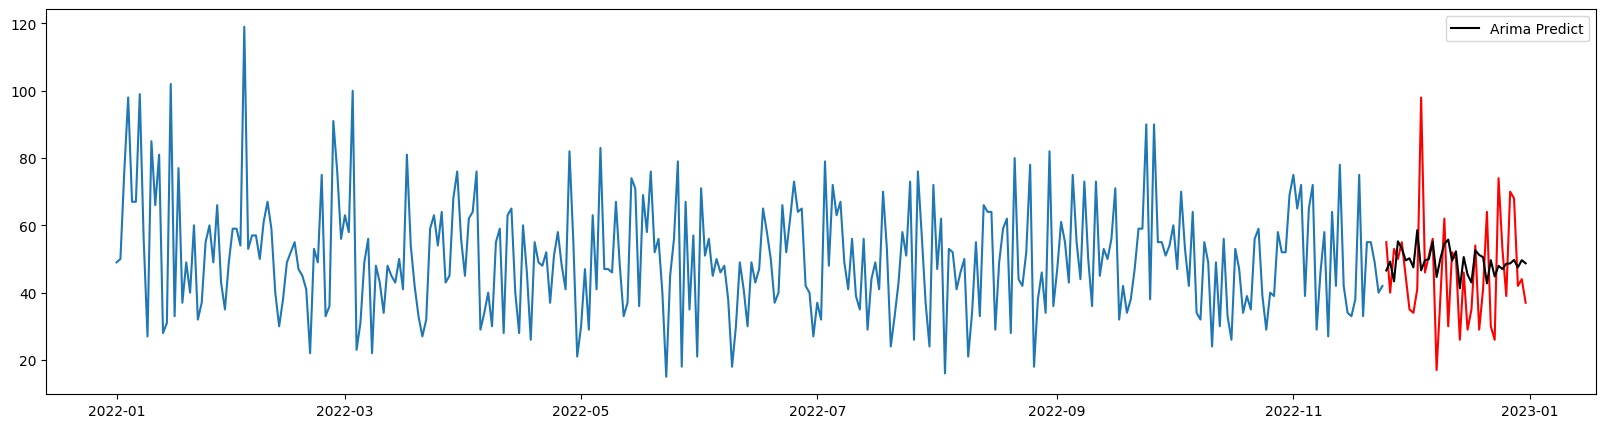

In [212]:
#ARIMA

train = train.set_index('Date')
test = test.set_index('Date')

y = train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test))

y_pred_df = y_pred.conf_int()
y_pred_df['Predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['Predictions']
eval(test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(train['Qty'])
plt.plot(test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label = "Arima Predict")
plt.legend()

## **Cluster**

In [213]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [214]:
df_cluster = df_merge.groupby(['CustomerID']).agg({'TransactionID':'count', 'Qty': 'sum', 'TotalAmount':'sum'}).reset_index()

In [215]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [216]:
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [217]:
cluster_data = df_cluster.drop(columns=['CustomerID'])
cluster_data_normalize = preprocessing.normalize(cluster_data)

In [218]:
cluster_data_normalize

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [219]:
#KMeans Approach

K = range(2,8)
fits = []
score = []
for k in K:
  model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(cluster_data_normalize)
  fits.append(model)
  score.append(silhouette_score(cluster_data_normalize, model.labels_, metric='euclidean'))

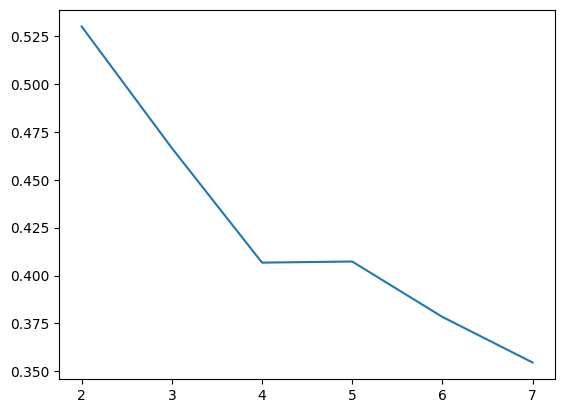

In [220]:
sns.lineplot(x = K, y = score);

In [221]:
df_cluster['cluster_label'] = fits[2].labels_

In [222]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean', 'TotalAmount' : 'mean'
})

,CustomerID,TransactionID,Qty,TotalAmount
cluster_label,,,,
0,128,11.601562,40.007812,418542.187500
1,28,9.250000,35.142857,225110.714286
2,156,11.628205,42.775641,383731.410256
3,135,10.829630,40.874074,313365.925926
